# 3. Molecular docking

Now that the models have been trained and one model has been chosen to be the most accurate in predicting the affinity values, the model can be used to classify more unknown compounds to eventually find more partcial agonists to the hA2BR. These compounds can later be docked to evaluate their position within the protein.

However, in this last phase, only the best predicted compound was docked, which was compound BTN1 (N#CC1=C(SCC2=NC=CN2)N=C(N)C(C#N)=C1C(C=C3)=CC=C3CCC4CC4). This compound was used as a proof of concept to test whether the docking in the hA2BR would be feasible. All of the crystal structures of the protein are quite new and not a lot of docking has been attempted. So, a proof of concept is actually very valuable in this instance.

In [96]:
#from pymol import cmd
import py3Dmol

import pandas as pd
import glob
import sys

from vina import Vina
#import pybel

from rdkit import Chem
from rdkit.Chem import AllChem, Draw

#from meeko import MoleculePreparation
#from meeko import obutils

import MDAnalysis as mda
from MDAnalysis.coordinates import PDB

#import prolif
#from prolif.plotting.network import LigNetwork

import nglview
from scripts import viewer

import sys, os, shutil
sys.path.insert(1, '/project/jhllei001/JHL_data/Jupyter_Dock/utilities')
# Note I had to comment out pymol, openmm and pdbfixer, hope it doesn't break later
#from utils import fix_protein, getbox, generate_ledock_file, pdbqt_to_sdf, dok_to_sdf

import warnings
warnings.filterwarnings("ignore")
%config Completer.use_jedi = False

An environment was made to work in and put in some files:

In [97]:
from pathlib import Path
HOMEDIR = str(Path.home())
os.chdir(HOMEDIR)
# We need to check whether the directory is there
try:
    os.mkdir('Docking')
except:
    print("Directory already exists")
os.chdir('Docking')

Directory already exists


## 3.1 Feching system and cleanup

For the next step, the protein, that was previously prepared, was extracted.

In [98]:
PDBCODE = '8HDO'
LIGAND_CODE = 'I5D'
shutil.copy('../Bioinformatics/{}_prepped.pdb'.format(PDBCODE), '{}_prepped.pdb'.format(PDBCODE))
shutil.copy('../Bioinformatics/ligand-{}.pdb'.format(LIGAND_CODE), 'ligand-{}.pdb'.format(LIGAND_CODE))

'ligand-I5D.pdb'

The 3D coordinate files of BAY 60-6583 (I5U) the novel ligand (BTN1) were generated.

In [99]:
test_smiles = [
    
    'C1CC1COC2=CC=C(C=C2)C3=C(C(=NC(=C3C#N)SCC(=O)N)N)C#N',    #I5D
    'N#CC1=C(SCC2=NC=CN2)N=C(N)C(C#N)=C1C(C=C3)=CC=C3CCC4CC4' #met Benthe en zonder O in alkenechain
]

The 3D files were generated using rdkit. The ligands were numbered automatically, so they are called ligand_00,ligand_01 etc.

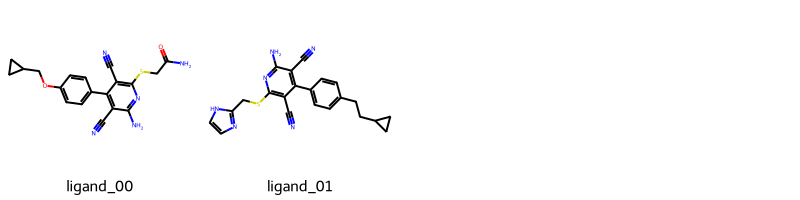

In [100]:
i = -1

IDs = []
for i in range(0,len(test_smiles)):
    base = 'ligand_{:02d}'.format(i)
    IDs.append(base)
    
df = pd.DataFrame({'ID':IDs, 'SMILES':test_smiles})

df['rdkit_mol'] = [Chem.MolFromSmiles(s) for s in df['SMILES']]

# Generate 2D images of the molecules
img=Draw.MolsToGridImage(df['rdkit_mol'].tolist(),
                            molsPerRow=4,
                            subImgSize=(200,200),
                            legends=df['ID'].tolist())

for i in range(len(df)):
    row = df.iloc[i]
    mol = row['rdkit_mol']
    name = row['ID'] + '.mol'
    Chem.MolToMolFile(mol,name)

img


## 3.2 System Visualization

The structure from Bioinformatics was retrieved. However, the novel ligand (green) was re-generated, which results in the loss of the coordinates. Therefore, it is not located in the binding pocket anymore. The original ligand (magenta) is generated in the right place.

In [101]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(PDBCODE),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})


view.addModel(open('ligand_00.mol','r').read(),format='mol2')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'greenCarbon','radius':0.2}})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModelsAsFrames(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

view.zoomTo()
view.show()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## 3.3 Docking with AutoDock Vina

AutoDock Vina (Vina) is one of the docking engines in the AutoDock Suite, together with AutoDock4 (AD4), AutoDockGPU, AutoDockFR, and AutoDock-CrankPep, and arguably among the most widely used and successful docking engines. The reasons for this success are mostly due to its ease of use and its speed (up to 100x faster than AD4), when compared to the other docking engines in the suite and elsewhere, as well as being open source.

### 3.3.1 Protein and ligand preparation

After sanitization, the protein docking preparation includes converting it to the PDBQT file format, which stores the atomic coordinates, partial charges, and AutoDock atom types for both the receptor and the ligand. 

The protein and both of the ligands were prepared.

In [102]:
from math import isnan, isinf

def PDBQTAtomLines(mol, donors, acceptors):
    """Create a list with PDBQT atom lines for each atom in molecule. Donors
    and acceptors are given as a list of atom indices.
    """

    atom_lines = [line.replace('HETATM', 'ATOM  ')
                  for line in Chem.MolToPDBBlock(mol).split('\n')
                  if line.startswith('HETATM') or line.startswith('ATOM')]

    pdbqt_lines = []
    for idx, atom in enumerate(mol.GetAtoms()):
        pdbqt_line = atom_lines[idx][:56]

        pdbqt_line += '0.00  0.00    '  # append empty vdW and ele
        # Get charge
        charge = 0.
        fields = ['_MMFF94Charge', '_GasteigerCharge', '_TriposPartialCharge']
        for f in fields:
            if atom.HasProp(f):
                charge = atom.GetDoubleProp(f)
                break
        # FIXME: this should not happen, blame RDKit
        if isnan(charge) or isinf(charge):
            charge = 0.
        pdbqt_line += ('%.3f' % charge).rjust(6)

        # Get atom type
        pdbqt_line += ' '
        atomicnum = atom.GetAtomicNum()
        if atomicnum == 6 and atom.GetIsAromatic():
            pdbqt_line += 'A'
        elif atomicnum == 7 and idx in acceptors:
            pdbqt_line += 'NA'
        elif atomicnum == 8 and idx in acceptors:
            pdbqt_line += 'OA'
        elif atomicnum == 1 and atom.GetNeighbors()[0].GetIdx() in donors:
            pdbqt_line += 'HD'
        else:
            pdbqt_line += atom.GetSymbol()
        pdbqt_lines.append(pdbqt_line)
    return pdbqt_lines

def MolToPDBQTBlock(mol, flexible=True, addHs=False, computeCharges=False):
    """Write RDKit Molecule to a PDBQT block

    Parameters
    ----------
        mol: rdkit.Chem.rdchem.Mol
            Molecule with a protein ligand complex
        flexible: bool (default=True)
            Should the molecule encode torsions. Ligands should be flexible,
            proteins in turn can be rigid.
        addHs: bool (default=False)
            The PDBQT format requires at least polar Hs on donors. By default Hs
            are added.
        computeCharges: bool (default=False)
            Should the partial charges be automatically computed. If the Hs are
            added the charges must and will be recomputed. If there are no
            partial charge information, they are set to 0.0.

    Returns
    -------
        block: str
            String wit PDBQT encoded molecule
    """
    # make a copy of molecule
    mol = Chem.Mol(mol)

    # if flexible molecule contains multiple fragments write them separately
    if flexible and len(Chem.GetMolFrags(mol)) > 1:
        return ''.join(MolToPDBQTBlock(frag, flexible=flexible, addHs=addHs,
                                       computeCharges=computeCharges)
                       for frag in Chem.GetMolFrags(mol, asMols=True))

    # Identify donors and acceptors for atom typing
    # Acceptors
    patt = Chem.MolFromSmarts('[$([O;H1;v2]),'
                              '$([O;H0;v2;!$(O=N-*),'
                              '$([O;-;!$(*-N=O)]),'
                              '$([o;+0])]),'
                              '$([n;+0;!X3;!$([n;H1](cc)cc),'
                              '$([$([N;H0]#[C&v4])]),'
                              '$([N&v3;H0;$(Nc)])]),'
                              '$([F;$(F-[#6]);!$(FC[F,Cl,Br,I])])]')
    acceptors = list(map(lambda x: x[0],
                         mol.GetSubstructMatches(patt, maxMatches=mol.GetNumAtoms())))
    # Donors
    patt = Chem.MolFromSmarts('[$([N&!H0&v3,N&!H0&+1&v4,n&H1&+0,$([$([Nv3](-C)(-C)-C)]),'
                              '$([$(n[n;H1]),'
                              '$(nc[n;H1])])]),'
                              # Guanidine can be tautormeic - e.g. Arginine
                              '$([NX3,NX2]([!O,!S])!@C(!@[NX3,NX2]([!O,!S]))!@[NX3,NX2]([!O,!S])),'
                              '$([O,S;H1;+0])]')
    donors = list(map(lambda x: x[0],
                      mol.GetSubstructMatches(patt, maxMatches=mol.GetNumAtoms())))
    if addHs:
        mol = Chem.AddHs(mol, addCoords=True, onlyOnAtoms=donors, )
    if addHs or computeCharges:
        AllChem.ComputeGasteigerCharges(mol)

    atom_lines = PDBQTAtomLines(mol, donors, acceptors)
    assert len(atom_lines) == mol.GetNumAtoms()

    pdbqt_lines = []

    # vina scores
    if (mol.HasProp('vina_affinity') and mol.HasProp('vina_rmsd_lb') and
            mol.HasProp('vina_rmsd_lb')):
        pdbqt_lines.append('REMARK VINA RESULT:  ' +
                           ('%.1f' % float(mol.GetProp('vina_affinity'))).rjust(8) +
                           ('%.3f' % float(mol.GetProp('vina_rmsd_lb'))).rjust(11) +
                           ('%.3f' % float(mol.GetProp('vina_rmsd_ub'))).rjust(11))

    pdbqt_lines.append('REMARK  Name = ' +
                       (mol.GetProp('_Name') if mol.HasProp('_Name') else ''))
    if flexible:
        # Find rotatable bonds
        rot_bond = Chem.MolFromSmarts('[!$(*#*)&!D1&!$(C(F)(F)F)&'
                                      '!$(C(Cl)(Cl)Cl)&'
                                      '!$(C(Br)(Br)Br)&'
                                      '!$(C([CH3])([CH3])[CH3])&'
                                      '!$([CD3](=[N,O,S])-!@[#7,O,S!D1])&'
                                      '!$([#7,O,S!D1]-!@[CD3]=[N,O,S])&'
                                      '!$([CD3](=[N+])-!@[#7!D1])&'
                                      '!$([#7!D1]-!@[CD3]=[N+])]-!@[!$(*#*)&'
                                      '!D1&!$(C(F)(F)F)&'
                                      '!$(C(Cl)(Cl)Cl)&'
                                      '!$(C(Br)(Br)Br)&'
                                      '!$(C([CH3])([CH3])[CH3])]')
        bond_atoms = list(mol.GetSubstructMatches(rot_bond))
        num_torsions = len(bond_atoms)

        # Active torsions header
        pdbqt_lines.append('REMARK  %i active torsions:' % num_torsions)
        pdbqt_lines.append('REMARK  status: (\'A\' for Active; \'I\' for Inactive)')
        for i, (a1, a2) in enumerate(bond_atoms):
            pdbqt_lines.append('REMARK%5.0i  A    between atoms: _%i  and  _%i'
                               % (i + 1, a1 + 1, a2 + 1))

        # Fragment molecule on bonds to ge rigid fragments
        bond_ids = [mol.GetBondBetweenAtoms(a1, a2).GetIdx()
                    for a1, a2 in bond_atoms]
        if bond_ids:
            mol_rigid_frags = Chem.FragmentOnBonds(mol, bond_ids, addDummies=False)
        else:
            mol_rigid_frags = mol
        frags = list(Chem.GetMolFrags(mol_rigid_frags))

        def weigh_frags(frag):
            """sort by the fragment size and the number of bonds (secondary)"""
            num_bonds = 0
            # bond_weight = 0
            for a1, a2 in bond_atoms:
                if a1 in frag or a2 in frag:
                    num_bonds += 1
                    # for frag2 in frags:
                    #     if a1 in frag2 or a2 in frag2:
                    #         bond_weight += len(frag2)

            # changed signs are fixing mixed sorting type (ascending/descending)
            return -len(frag), -num_bonds,  # bond_weight
        frags = sorted(frags, key=weigh_frags)

        # Start writting the lines with ROOT
        pdbqt_lines.append('ROOT')
        frag = frags.pop(0)
        for idx in frag:
            pdbqt_lines.append(atom_lines[idx])
        pdbqt_lines.append('ENDROOT')

        # Now build the tree of torsions usign DFS algorithm. Keep track of last
        # route with following variables to move down the tree and close branches
        branch_queue = []
        current_root = frag
        old_roots = [frag]

        visited_frags = []
        visited_bonds = []
        while len(frags) > len(visited_frags):
            end_branch = True
            for frag_num, frag in enumerate(frags):
                for bond_num, (a1, a2) in enumerate(bond_atoms):
                    if (frag_num not in visited_frags and
                        bond_num not in visited_bonds and
                        (a1 in current_root and a2 in frag or
                         a2 in current_root and a1 in frag)):
                        # direction of bonds is important
                        if a1 in current_root:
                            bond_dir = '%i %i' % (a1 + 1, a2 + 1)
                        else:
                            bond_dir = '%i %i' % (a2 + 1, a1 + 1)
                        pdbqt_lines.append('BRANCH %s' % bond_dir)
                        for idx in frag:
                            pdbqt_lines.append(atom_lines[idx])
                        branch_queue.append('ENDBRANCH %s' % bond_dir)

                        # Overwrite current root and stash previous one in queue
                        old_roots.append(current_root)
                        current_root = frag

                        # remove used elements from stack
                        visited_frags.append(frag_num)
                        visited_bonds.append(bond_num)

                        # mark that we dont want to end branch yet
                        end_branch = False
                        break
                    else:
                        continue
                    break  # break the outer loop as well

            if end_branch:
                pdbqt_lines.append(branch_queue.pop())
                if old_roots:
                    current_root = old_roots.pop()
        # close opened branches if any is open
        while len(branch_queue):
            pdbqt_lines.append(branch_queue.pop())
        pdbqt_lines.append('TORSDOF %i' % num_torsions)
    else:
        pdbqt_lines.extend(atom_lines)

    return '\n'.join(pdbqt_lines)

def MolFromPDBQTBlock(filename, sanitize=True, removeHs=True):
    """Read PDBQT block to a RDKit Molecule
    Parameters
    ----------
        block: string
            Residue name which explicitly pint to a ligand(s).
        sanitize: bool (default=True)
            Should the sanitization be performed
        removeHs: bool (default=True)
            Should hydrogens be removed when reading molecule.
    Returns
    -------
        mol: rdkit.Chem.rdchem.Mol
            Molecule read from PDBQT
    """
    pdb_lines = []
    name = ''
    data = {}
    with open(filename) as file:
        lines = file.readlines()
        block = [line.rstrip() for line in lines]
        
    for line in block: #.split('\n'):
        # Get all know data from REMARK section
        if line[:12] == 'REMARK  Name':
            name = line[15:].strip()
        elif line[:18] == 'REMARK VINA RESULT':
            tmp = line[19:].split()
            data['vina_affinity'] = tmp[0]
            data['vina_rmsd_lb'] = tmp[1]
            data['vina_rmsd_ub'] = tmp[2]

        # no more data to collect
        if line[:4] != 'ATOM':
            continue

        pdb_line = line[:56]
        pdb_line += '1.00  0.00           '

        # Do proper atom type lookup
        atom_type = line[71:].split()[1]
        if atom_type == 'A':
            atom_type = 'C'
        elif atom_type[:1] == 'O':
            atom_type = 'O'
        elif atom_type[:1] == 'H':
            atom_type = 'H'
            if removeHs:
                continue
        elif atom_type == 'NA':
            atom_type = 'N'

        pdb_lines.append(pdb_line + atom_type)
    mol = Chem.MolFromPDBBlock('\n'.join(pdb_lines), sanitize=False)
    if sanitize:
        Chem.SanitizeMol(mol)
    else:
        Chem.GetSSSR(mol)
    # reorder atoms using serial
    new_order = sorted(range(mol.GetNumAtoms()),
                       key=lambda i: (mol.GetAtomWithIdx(i)
                                      .GetPDBResidueInfo()
                                      .GetSerialNumber()))
    mol = Chem.RenumberAtoms(mol, new_order)

    # properties must be set on final copy of Mol, RenumberAtoms purges data
    mol.SetProp('_Name', name)
    for k, v in data.items():
        mol.SetProp(str(k), str(v))

    return mol

### 3.3.2 Box definition

It has been shown that using the radius of gyration, an efficient box can be generated for the docking process:
FROM: https://jcheminf.biomedcentral.com/articles/10.1186/s13321-015-0067-5
The radius of gyration, as well as the center of geometry of the ligand were generated to define the box size.

In [104]:
import math

def Rg(filename):
    '''
    Calculates the Radius of Gyration (Rg) of a protein given its .pdb 
    structure file. Returns the Rg integer value in Angstrom.
    '''
    coord = list()
    mass = list()
    Structure = open(filename, 'r')
    for line in Structure:
        try:
            line = line.split()
            x = float(line[6])
            y = float(line[7])
            z = float(line[8])
            coord.append([x, y, z])
            if line[-1] == 'C':
                mass.append(12.0107)
            elif line[-1] == 'O':
                mass.append(15.9994)
            elif line[-1] == 'N':
                mass.append(14.0067)
            elif line[-1] == 'S':
                mass.append(32.065)
        except:
            pass
    xm = [(m*i, m*j, m*k) for (i, j, k), m in zip(coord, mass)]
    tmass = sum(mass)
    rr = sum(mi*i + mj*j + mk*k for (i, j, k), (mi, mj, mk) in zip(coord, xm))
    mm = sum((sum(i) / tmass)**2 for i in zip(*xm))
    rg = math.sqrt(rr / tmass-mm)
    return(round(rg, 3))

# Calculate the center based on the reference ligand
Rg = Rg('ligand-{}.pdb'.format(LIGAND_CODE))
print("Radius of Gyration = {}".format(Rg))

Radius of Gyration = 4.637


In [105]:
# Calculate center of geometry
def COG(pdbfile, include='ATOM,HETATM'):
    """
    Calculates center of geometry of a protein and/or ligand structure.
    Returns:
        center (list): List of float coordinates [x,y,z] that represent the
        center of geometry (precision 3).
    """

    center = [None, None, None]
    include = tuple(include.split(','))

    with open(pdbfile) as pdb:

        # extract coordinates [ [x1,y1,z1], [x2,y2,z2], ... ]
        coordinates = []
        for line in pdb:
            if line.startswith(include):
                coordinates.append([float(line[30:38]),    # x_coord
                                    float(line[38:46]),    # y_coord
                                    float(line[46:54])     # z_coord
                                   ])

        # calculate center of geometry
        center = [sum([coordinates[i][j]/(len(coordinates))
              for i in range(len(coordinates))]) for j in range(3)]
        center = [round(center[i], 3) for i in range(3)]
    return center

CenterOfGeometry = COG('ligand-{}.pdb'.format(LIGAND_CODE))
print("Center Of Geometry = {}".format(CenterOfGeometry))

Center Of Geometry = [138.276, 127.761, 106.258]


### 3.3.4 Docking

AutoDock Vina 1.2.0, which was recently released, now allows AutoDock Vina to be executed using Python Bindings.

Both of the ligands were docked seperatly.

In [106]:
protein = Chem.MolFromPDBFile('{}_prepped.pdb'.format(PDBCODE))
a = MolToPDBQTBlock(protein,flexible=False)
with open('protein.pdbqt','w') as outfile:
    for line in a:
        outfile.write(line)

In [107]:
# You can change the ligand name for each of the generated molecules from your smiles:
# So, ligand_00 (Should be the reference ligand from the crystal structure)
# Then, ligand_01, ligand_02, ... etc.
# Run one ligand at the time!
LIGAND_TO_DOCK = 'ligand_01' # Write the ligand you want to dock here.
m = Chem.MolFromMolFile('{}.mol'.format(LIGAND_TO_DOCK))
a = MolToPDBQTBlock(m)
with open('{}.pdbqt'.format(LIGAND_TO_DOCK), 'w') as outfile:
    for line in a:
        outfile.write(line)

***This step takes a while!***

In [108]:
v = Vina(sf_name='vina')

v.set_receptor('protein.pdbqt')

v.set_ligand_from_file('{}.pdbqt'.format(LIGAND_TO_DOCK))

center = {
     'center_x' : CenterOfGeometry[0], 
     'center_y' : CenterOfGeometry[1], 
     'center_z' : CenterOfGeometry[2]
     
}

size = { 
    'size_x' : Rg * 2.9 ,
    'size_y' : Rg * 2.9,
    'size_z' : Rg * 2.9,           
           }
 

v.compute_vina_maps(center=[center['center_x'], center['center_y'], center['center_z']], 
                    box_size=[size['size_x'], size['size_y'], size['size_z']])

'''
# Score the current pose
energy = v.score()
print('Score before minimization: %.3f (kcal/mol)' % energy[0])

# Minimized locally the current pose
energy_minimized = v.optimize()
print('Score after minimization : %.3f (kcal/mol)' % energy_minimized[0])
v.write_pose('1iep_ligand_minimized.pdbqt', overwrite=True)
'''

# Dock the ligand
v.dock(exhaustiveness=10, n_poses=10)
v.write_poses('docking_results.pdbqt', n_poses=1, overwrite=True)


mode |   affinity | dist from best mode
     | (kcal/mol) | rmsd l.b.| rmsd u.b.
-----+------------+----------+----------
   1       -7.975          0          0
   2       -7.664      2.184      4.084
   3       -7.505      2.785      9.545
   4       -7.035      2.232      4.456
   5       -6.932       1.72      3.614
   6        -6.89      2.646      9.803
   7       -6.864      3.325      9.449
   8       -6.737      2.881      8.985
   9       -6.717       2.96      9.817
  10      -0.1347      3.203      8.548
Computing Vina grid ... done.
Performing docking (random seed: -1366927508) ... 
0%   10   20   30   40   50   60   70   80   90   100%
|----|----|----|----|----|----|----|----|----|----|
***************************************************


In [109]:
# Create a mol object from the docking results, write the mol to file and print the predicted affinity
mol = MolFromPDBQTBlock('docking_results.pdbqt',sanitize=False)
Chem.rdmolfiles.MolToPDBFile(mol, '{}_docked.pdb'.format(LIGAND_TO_DOCK))
Ki = (math.exp(float(mol.GetProp('vina_affinity'))/0.592))
pKi = -math.log10(Ki)
pChEMBL = pKi
print('The affinity predicted by Vina = {} (kcal/mol)'.format(mol.GetProp('vina_affinity')))
print('Which (approximately) corresponds to a pChEMBL of {:.2f}'.format(pKi))

The affinity predicted by Vina = -8.035 (kcal/mol)
Which (approximately) corresponds to a pChEMBL of 5.89


### 3.3.5 3D visualization of docking results

As with the system visualization (section 3), the docking results can be inspected and compared to the reference structure (if exist). The ligand's "Pose" and "Score" information will also be displayed to show how acces to this molecule's attributes.

In [110]:
view = py3Dmol.view()
view.removeAllModels()
view.setViewStyle({'style':'outline','color':'black','width':0.1})

view.addModel(open('{}_prepped.pdb'.format(PDBCODE),'r').read(),format='pdb')
Prot=view.getModel()
Prot.setStyle({'cartoon':{'arrows':True, 'tubes':True, 'style':'oval', 'color':'white'}})
view.addSurface(py3Dmol.VDW,{'opacity':0.6,'color':'white'})

ligtmp = 'ligand-{}.pdb'.format(LIGAND_CODE)
view.addModels(open(ligtmp,'r').read(),format='pdb')
ref_m = view.getModel()
ref_m.setStyle({},{'stick':{'colorscheme':'magentaCarbon','radius':0.2}})

docktmp = '{}_docked.pdb'.format(LIGAND_TO_DOCK)
view.addModels(open(docktmp,'r').read(),format='pdb')
x = view.getModel()
x.setStyle({},{'stick':{'colorscheme':'cyanCarbon','radius':0.2}})

print('Reference: Magenta | Vina Pose: Cyan')

view.zoomTo()
view.show()

Reference: Magenta | Vina Pose: Cyan


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

With the nglviewer key interactions can be viewed:

In [111]:
# combine protein and ligand files
filenames = [
'{}_prepped.pdb'.format(PDBCODE),
'{}_docked.pdb'.format(LIGAND_TO_DOCK)
]
with open('{}-complex.pdb'.format(PDBCODE), 'w') as outfile:
    for fname in filenames:
        with open(fname) as infile:
            for line in infile:
                if not "END" in line:
                    outfile.write(line)

In [112]:
# docktmp = '{}_docked.pdb'.format(LIGAND_TO_DOCK

with open('{}-complex.pdb'.format(PDBCODE)) as f:
    view = nglview.show_file(f, ext="pdb")
    
view.center("UNL")
view

NGLWidget()

As a reminder, this is how the original ligand was positioned in the BioInformatics study:

![image info](img/8HDO_I5D.png)
*Figure 3.1: The original position of BAY 60-6583, as generated in the first part of the study.*

And this is how the original ligand is docked with AutoVina:

![image info](img/8HDO_I5D_Docked.png)
*Figure 3.2: The position of BAY 60-6583, as predicted by AutoVina.*

## 3.4 Results

Both the original ligand itself and the novel ligand dock in a flipped position, compared to the position of the original ligand in the Bioinformatics study. The two ligands have been docked five individual times and all were turned around. The position of BAY 60-6583 is actually not matching in literature itself. The PDB shows the cyclopropyl to be faced towards the outside of the protein. At the same time, Chen et al.[8] predicts the cyclopropyl to be facing inwards. AutoVina docks BAY 60-6583 and BTN1 consistanly the same, with the cyclopropyl towards to protein. 

The pCHEMBL value that was calculated by AutoVina of the original ligand was on average 5.45. The pCHEMBL of BTN1 was on average 5.88. These values are significantly lower compared to the pCHEMBL values that were calculated by the RF model (7.05 and 7.26, respectively). Moreover, the difference between the affinity of the ligands is 2 times higher with the calculation by AutoVina. 

Even though AutoVina is a open-source, fast and easily usable docking platform, it is also not the most reliable. The accuracy could be improved by adjusting the exhaustiveness and the amount of generated poses. However, this undermines the fast docking that makes AutoVina a useful tool. AutoVina also only includes one protein conformation when docking a ligand, even though a protein is flexible. The RF model compares structures of ligands that can bind to more conformations and thus keeps up with the flexibility of the protein. Therefore, the pCHEMBL values of the RF model are expected to be more accurate when producing and testing these compounds in the lab.

Speaking of which, many compounds that are generated by computational models are not feasible in the lab. The synthesis could either be too hard and expensive or not possible at all. Therefore, if compounds are used in docking, it would be wise to check whether their synthesis is feasible, before suggesting any further wet-lab research.

Our compound BTN1 is actually synthesizable with the following procedure:

![image info](img/Synthesis_route_Catarzi.jpg)
*Figure 3.3: The last steps of the synthesis of BTN1, adapted from Catarzi et al.*

Most of the synthesis route was obtained from Catarzi et al.[3] However, since the first building block differs from our ligand, the synthesis had to be adjusted accordingly. Our starting building block is not commercially available and therefore, a previous step of the synthesis was added to produce this building block. This step was developed by searching for similar reactions using Reaxys. The reaction was adapted from Taisho Pharmaceutical Holdings for compound EP2881384A1 in 2015 (ReaxysID = 40274687).

![image info](img/Synthesis_route_first_step.jpg)
*Figure 3.4: The first step of the synthesis of BTN1, adapated from ReaxysID 40274687*


# 4. Summary and future prospects

In this study a novel ligand was generated with a predicted high affinity towards the hA2BR. Firstly, the protein and possible off-targets were investigated and prepared. Later, a RF model was created with the available biochemical data of known binders to the target. The model was then used to examine which R-groups of the original ligand were crucial to the binding to the hA2BR. By combining this information, a novel ligand was created. This ligand was docked to analyze the pose and compare it to the pose of the original ligand.

During this study one protein structure was used. As mentioned before, there are only four available at the moment. However, none of them have a great resolution. So, this study could be repeated once more crystal structures have been released. This would also allow for possibly docking in more conformations of the protein and might resolve the positioning of the ligands, as it is still unclear whether the cyclopropyl is facing towards the protein or not.

Moreover, a temporal split could be used to split the dataset when training the models. Now, a random split was used, which not only produced different pCHEMBL values every time, but it could also lead to overfitting. When a random split is used, there is no control over which compounds end up in the training or test set. The temporal split prevents this. However, it is a harder procedure, so the random split was the right choice for this shorter project.

Lastly, the novel compound and additional derivatives could be synthesized and tested for their affinity to the hA2BR. These results could be compared to the pCHEMBLs that both the RF model and AutoVina produced. The assumption that the prediction of the RF model would be better could then be examined. 

### References:

[1] Korkutata, M., & Lazarus, M. (2023). Adenosine A2A receptors and sleep (Vol. 170). International Review of Neurobiology. doi: 10.1016/bs.irn.2023.04.007.

[2] Vincenzi F, Pasquini S, Contri C, Cappello M, Nigro M, Travagli A, Merighi S, Gessi S, Borea PA, Varani K. Pharmacology of Adenosine Receptors: Recent Advancements. Biomolecules. 2023 Sep 14;13(9):1387. doi: 10.3390/biom13091387.

[3] Catarzi D, Varano F, Varani K, Vincenzi F, Pasquini S, Dal Ben D, Volpini R, Colotta V. Amino-3,5-Dicyanopyridines Targeting the Adenosine Receptors Ranging from Pan Ligands to Combined A1/A2B Partial Agonists. Pharmaceuticals (Basel). 2019 Oct 22;12(4):159. doi: 10.3390/ph12040159.

[4] Adenosine receptor A2B | DrugBank Online. (z.d.). DrugBank. Geraadpleegd op 8 november 2023, van https://go.drugbank.com/bio_entities/BE0000241.

[5] Bank, R. P. D. RCSB PDB - 8HDO: Structure of A2BR bound to Synthetic Agonists BAY 60-6583. Geraadpleegd op 8 november 2023, van https://www.rcsb.org/structure/8HDO.

[6] Bank, R. P. D. RCSB PDB - 8HDP: Structure of A2BR bound to Endogenous Agonists adenosine. Geraadpleegd op 8 november 2023, van https://www.rcsb.org/structure/8HDP.

[7] National Center for Biotechnology Information (2023). PubChem Compound Summary for CID 11717831, 2-({6-Amino-3,5-dicyano-4-[4-(cyclopropylmethoxy)phenyl]pyridin-2-yl}sulfanyl)acetamide. Retrieved November 8, 2023 from https://pubchem.ncbi.nlm.nih.gov/compound/bay-60-6583.

[8] Chen Y, Zhang J, Weng Y, Xu Y, Lu W, Liu W, Liu M, Hua T, Song G. Cryo-EM structure of the human adenosine A2B receptor-Gs signaling complex. Sci Adv. 2022 Dec 23;8(51):eadd3709. doi: 10.1126/sciadv.add3709.